<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C2/W3/ungraded_lab/C2_W3_Lab_1_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Transfer Learning

In this lab, you will see how you can use a pre-trained model to achieve good results even with a small training dataset. This is called _transfer learning_ and you do this by leveraging the trained layers of an existing model and adding your own layers to fit your application. For example, you can:

1. just get the convolution layers of one model
2. attach some dense layers onto it
3. train just the dense network
4. evaluate the results

Doing this will allow you to save time building your application because you will essentially skip weeks of training time of very deep networks. You will just use the features it has learned and tweak it for your dataset. Let's see how these are done in the next sections.

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running the notebook on your local machine might result in some of the code blocks throwing errors.

## Setup the pretrained model

You will need to prepare pretrained model and configure the layers that you need. For this exercise, you will use the convolution layers of the [InceptionV3](https://arxiv.org/abs/1512.00567) architecture as your base model. To do that, you need to:

1. Set the input shape to fit your application. In this case. set it to `150x150x3` as you've been doing in the last few labs.

2. Pick and freeze the convolution layers to take advantage of the features it has learned already.

3. Add dense layers which you will train.

Let's see how to do these in the next cells.

First, in preparing the input to the model, you want to fetch the pretrained weights of the `InceptionV3` model and remove the fully connected layer at the end because you will be replacing it later. You will also specify the input shape that your model will accept. Lastly, you want to freeze the weights of these layers because they have been trained already.

In [40]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
# local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
# model= tf.keras.applications.VGG19( include_top=True, weights="imagenet", input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation="softmax", )
# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = MobileNetV2(#include_top=False, 
                                #weights="imagenet", 
                                #input_tensor=None, 
                                input_shape=(224, 224, 3)
                                #pooling=None, 
                                #classes=3
                                #classifier_activation="softmax"
                                )
                                
pre_trained_model.save('mobilenet_v2.h5')

# Load the pre-trained weights you downloaded.
#pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
    layer.trainable = False


You can see the summary of the model below. You can see that it is a very deep network. You can then select up to which point of the network you want to use. As Laurence showed in the exercise, you will use up to `mixed_7` as your base model and add to that. This is because the original last layer might be too specialized in what it has learned so it might not translate well into your application. `mixed_7` on the other hand will be more generalized and you can start with that for your application. After the exercise, feel free to modify and use other layers to see what the results you get.

In [41]:
pre_trained_model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [8]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

AttributeError: 'KerasLayer' object has no attribute 'get_layer'

## Add dense layers for your classifier

Next, you will add dense layers to your model. These will be the layers that you will train and is tasked with recognizing cats and dogs. You will add a [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer as well to regularize the output and avoid overfitting.

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1000)              3538984   
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 3003      
Total params: 3,541,987
Trainable params: 3,003
Non-trainable params: 3,538,984
_________________________________________________________________


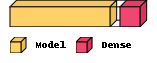

In [53]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    pre_trained_model,
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    #tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    #tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    #tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    #tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    #tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    #tf.keras.layers.Flatten(),
    #tf.keras.layers.Dropout(0.3),
    #tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Print the model summary
model.summary()

#! pip install visualkeras
import visualkeras
visualkeras.layered_view(model, legend=True)

## Prepare the dataset

Now you will prepare the dataset. This is basically the same code as the one you used in the data augmentation lab.

In [43]:
import os

base_dir = 'train/'

chernozem_dir = os.path.join(base_dir, 'chernozem')
laterite_dir = os.path.join(base_dir, 'laterite')
podsolik_dir = os.path.join(base_dir, 'podsolik')

print('total training chernozem images:', len(os.listdir(chernozem_dir)))

chernozem_files = os.listdir(chernozem_dir)
print(chernozem_files[:10])

total training chernozem images: 179
['85.jpg', '101.jpg', '163.jpg', '132.jpg', '39.jpg', '179.jpg', '176.jpg', '177.jpg', '122.jpg', '153.jpg']


## Train the model

With that, you can now train the model. You will do 20 epochs and plot the results afterwards.

In [54]:
# Set the training parameters
#model.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

from tensorflow.keras.optimizers import RMSprop

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])

In [56]:
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "train/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "test/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(224, 224),
	class_mode='categorical',
  batch_size=10
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=10
)

Found 348 images belonging to 3 classes.
Found 85 images belonging to 3 classes.


In [57]:
# Train the model
history = model.fit(train_generator, epochs=10, steps_per_epoch=5, validation_data = validation_generator, verbose = 1, validation_steps=5)

Train for 5 steps, validate for 5 steps
Epoch 1/10
5/5 [==============================] - 62s 12s/step - loss: 1.0803 - accuracy: 0.5000 - val_loss: 1.0792 - val_accuracy: 0.5600
Epoch 2/10
5/5 [==============================] - 59s 12s/step - loss: 1.0772 - accuracy: 0.5200 - val_loss: 1.0769 - val_accuracy: 0.5600
Epoch 3/10
5/5 [==============================] - 58s 12s/step - loss: 1.0802 - accuracy: 0.4792 - val_loss: 1.0747 - val_accuracy: 0.5600
Epoch 4/10
5/5 [==============================] - 60s 12s/step - loss: 1.0713 - accuracy: 0.5200 - val_loss: 1.0723 - val_accuracy: 0.5400
Epoch 5/10
5/5 [==============================] - 61s 12s/step - loss: 1.0698 - accuracy: 0.5000 - val_loss: 1.0699 - val_accuracy: 0.5400
Epoch 6/10
5/5 [==============================] - 54s 11s/step - loss: 1.0541 - accuracy: 0.6400 - val_loss: 1.0667 - val_accuracy: 0.5600
Epoch 7/10
5/5 [==============================] - 54s 11s/step - loss: 1.0670 - accuracy: 0.5200 - val_loss: 1.0645 - val_accu

## Evaluate the results

You will use the same code to plot the results. As you can see, the validation accuracy is also trending upwards as your training accuracy improves. This is a good sign that your model is no longer overfitting!

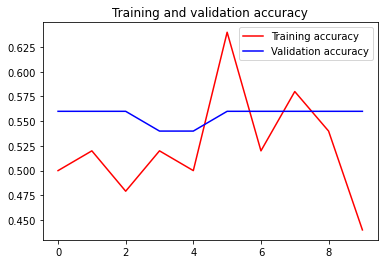

<Figure size 432x288 with 0 Axes>

In [58]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()